# 基于LSTM的城市空气质量指数预测

### 陈沛宇 518021910489
#### pietychen@sjtu.edu.cn
## 需求分析
空气质量近年来备受民众关注，而环境空气质量由多种污染物浓度共同决定，对单一污染物进行观测无法让我们全面的了解到当前环境空气质量。环境空气质量指数(AQI)将二氧化硫、二氧化氮、PM10、PM2.5、一氧化碳和臭氧，共6项污染物用统一的评价标准呈现。环境空气质量指数(AQI)是用来对空气质量进行定量描述的数据，它描述了空气清洁或者污染的程度，以及对健康的影响。

空气质量往往呈现周期性波动，如有供暖需求的北方城市每当在冬季时环境空气质量指数就会有所增高。空气质量往往也与近期活动有关，如连续多天空气质量较差那接下来的一天空气质量也大概率不会特别好。对环境空气质量指数有一定的预测能力将帮助我们在出行，运动等等方面制定更合理的计划。

考虑到空气质量可能同时收长期和短期的影响，本项目搜集了北京、成都、重庆、杭州、上海以及深圳共国内六个城市，对六个城市的历年的环境空气质量做了一定的统计分析，并使用了长短期记忆LSTM模型对上海未来30天的环境空气质量指数进行了预测。

## 数据获取

通过爬虫程序获取了本次项目的数据集，爬虫爬取的网站为[***天气后报***](http://www.tianqihoubao.com/aqi)，该网站记录了2013-2020七年国内各大城市每日的平均AQI，AQI排名以及上面列举的六大污染物数据。

通过对网站url的分析发现url呈现规律为：

```
http://www.tianqihoubao.com/aqi/cityname-yearmonth.html
```



In [ ]:
# 导入爬虫需要的库
import requests
from bs4 import BeautifulSoup
import csv

In [ ]:
# 设置头部信息，伪装为浏览器
headers = {"User-Agent":"Mozilla/5.0 (Linux; Android 4.1.1; Nexus 7 Build/JRO03D) AppleWebKit/535.19 (KHTML, like Gecko) Chrome/18.0.1025.166 Safari/535.19"}

city = ['shanghai','chongqing','beijing','hangzhou','chengdu','shenzhen']
years= ['2014','2015','2016','2017','2018','2019','2020']
months= ['01','02','03','04','05','06','07','08','09','10','11','12']
prefix = "http://www.tianqihoubao.com/aqi/"

# 使用函数生成数百个个url链接，无需进行冗余的列举工作
def get_url(city_name):
    url = []
    url.append(prefix + city_name + '-201311.html')
    url.append(prefix + city_name + '-201312.html')
    for i in range(len(years)):
        temp = prefix + city_name + '-' + years[i]
        for j in range(len(months)):
            url.append(temp + months[j] + '.html')
    url.pop()
    return url
             
# 获取每个城市的url    
url_sh = get_url('shanghai')
url_bj = get_url('beijing')
url_hz = get_url('hangzhou')
url_cq = get_url('chongqing')
url_cd = get_url('chengdu')
url_sz = get_url('shenzhen')

通过分析网站html源码，发现本项目需要的信息在位于*api_month_list->tr->td*下

In [ ]:
# 爬取数据，并储存为.csv文件
def crawler(urls,city):
    header = 0
    print(city)
    for i in range(len(urls)):
        print(urls[i])
        print("month count:",i)
        response = requests.get( urls[i] , headers=headers )
        print("response status code:",response.status_code)
        
        index = 0
        soup = BeautifulSoup(response.content, 'lxml')
        datas = soup.find('div', class_ = "api_month_list")
        file_name = 'datas_'+city+'.csv'
        csv_file = open(file_name, 'a', encoding="utf-8", newline='')
        if header == 0:
            csv.writer(csv_file).writerow(["date","AQI_index","AQI_rank","PM2.5","PM10","SO2","NO2","CO","O3"])
        header +=1
        for data in datas.find_all("tr"):
            index += 1
            if index == 1:
                continue
            all_td = data.find_all('td')
            csv.writer(csv_file).writerow([all_td[0].text,all_td[2].text,all_td[3].text,all_td[4].text,all_td[5].text,all_td[6].text,all_td[7].text,all_td[8].text,all_td[9].text])
            index += 1
        #关闭
        csv_file.close()

In [ ]:
crawler(url_sh,'shanghai')
crawler(url_sz,'shenzhen')
crawler(url_bj,'beijing')
crawler(url_cd,'chengdu')
crawler(url_hz,'hangzhou')
crawler(url_cq,'chongqing')

## 数据预处理——数据统计分析

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from pylab import rcParams

### 超参数设置（1）

In [6]:
# per day细粒度的数据分析抖动过于巨大，设置窗口大小为30天（per month）
window_size = 30
look_back = window_size
# 设置LSTM训练集大小
training_set_size = 0.8

In [7]:
# 读取爬取得到的六个城市的数据
data_bj = pd.read_csv('./datas_beijing.csv')
data_cd = pd.read_csv('./datas_chengdu.csv')
data_cq = pd.read_csv('./datas_chongqing.csv')
data_hz = pd.read_csv('./datas_hangzhou.csv')
data_sh = pd.read_csv('./datas_shanghai.csv')
data_sz = pd.read_csv('./datas_shenzhen.csv')


#去除爬虫爬取到的date列的 \r \n
def del_date(city_data):
    city_data['date'] = city_data['date'].str.replace('\r','').str.replace('\n','').str.replace(' ','')
    return city_data


# -------------------------
data_bj = del_date(data_bj)
data_cd = del_date(data_cd)
data_cq = del_date(data_cq)
data_hz = del_date(data_hz)
data_sh = del_date(data_sh)
data_sz = del_date(data_sz)
# -------------------------

### 检查是否存在错误数据

In [8]:
# 检查是否有null值
def cnt_null(city_data):
    missing_data = city_data.isnull()
    # 将columns的名字转为一个list便于迭代
    for column in missing_data.columns.values.tolist():
        print(column)
        print(missing_data[column].value_counts(),'\n')

cnt_null(data_bj)

date
False    2542
Name: date, dtype: int64 

AQI_index
False    2542
Name: AQI_index, dtype: int64 

AQI_rank
False    2542
Name: AQI_rank, dtype: int64 

PM2.5
False    2542
Name: PM2.5, dtype: int64 

PM10
False    2542
Name: PM10, dtype: int64 

SO2
False    2542
Name: SO2, dtype: int64 

NO2
False    2542
Name: NO2, dtype: int64 

CO
False    2542
Name: CO, dtype: int64 

O3
False    2542
Name: O3, dtype: int64 



由以上输出看出，数据中不存在缺失值。

In [9]:
# 检查是否有小于0的不正确值
def cnt_zero(city_data):
    zero_check = city_data.drop(columns=['date'])
    zero_check[zero_check<0] = np.nan
    nan_num = zero_check.isna().sum()
    return nan_num

print(cnt_zero(data_bj))

AQI_index    0
AQI_rank     0
PM2.5        0
PM10         0
SO2          0
NO2          0
CO           0
O3           0
dtype: int64


由以上输出看出，数据中不存在小于0的错误值。

将date列拆分为年/月/日三列加入数据集，方便后续进行针对年/月/日的数据统计分析：

In [10]:
def split_date(city_data):
    new_names = ['Year','Month','Day']
    splits = city_data['date'].str.split('-', expand=True)
    splits.columns = new_names
     # 数据合并
    city_data = city_data.join(splits)
    return city_data

# ---------------------------
data_bj = split_date(data_bj)
data_cd = split_date(data_cd) 
data_cq = split_date(data_cq) 
data_hz = split_date(data_hz) 
data_sh = split_date(data_sh) 
data_sz = split_date(data_sz) 
# ---------------------------

In [11]:
# 查看当前dataframe中每一列的数据类型
print(data_bj.dtypes)

date          object
AQI_index      int64
AQI_rank       int64
PM2.5          int64
PM10           int64
SO2            int64
NO2            int64
CO           float64
O3             int64
Year          object
Month         object
Day           object
dtype: object


object类型的数据是不方便我们后续使用的，故在此将其转变为int64数据类型

In [12]:
# 修改数据类型
# -----------------------------------------------------------------------------------
data_bj[['Year', 'Month', 'Day']] = data_bj[['Year', 'Month', 'Day']].astype("int64")
data_cd[['Year', 'Month', 'Day']] = data_cd[['Year', 'Month', 'Day']].astype("int64")
data_cq[['Year', 'Month', 'Day']] = data_cq[['Year', 'Month', 'Day']].astype("int64")
data_hz[['Year', 'Month', 'Day']] = data_hz[['Year', 'Month', 'Day']].astype("int64")
data_sh[['Year', 'Month', 'Day']] = data_sh[['Year', 'Month', 'Day']].astype("int64")
data_sz[['Year', 'Month', 'Day']] = data_sz[['Year', 'Month', 'Day']].astype("int64")
# -----------------------------------------------------------------------------------

## 数据分析与数据可视化
一座城市某一年空气质量指数或是污染物数据的最大最小值可以帮助我们构建对这座城市空气质量的第一印象，对这些数据的均值，标准差，中值进行分析也也能帮助我们更全面的了解一座城市的环境。

In [13]:
# 按年获取某城市感兴趣指标的最大值
def get_max(city_data, column_name,year):
    temp=city_data[city_data['Year'].isin([year])]
    max_idx = temp.loc[:,[column_name]].idxmax()
    return temp[column_name][max_idx].item(),temp['date'][max_idx].item()


# 按年获取某城市感兴趣指标的最大值
def get_min(city_data, column_name,year):
    temp=city_data[city_data['Year'].isin([year])]
    min_idx = temp.loc[:,[column_name]].idxmin()
    return temp[column_name][min_idx].item(),temp['date'][min_idx].item()


# 按年获取某城市感兴趣指标的均值，标准差，中值
def get_des(city_data,column_name,year,func):
    temp=city_data[city_data['Year'].isin([year])]
    data_describe = temp.describe().drop(columns = ['Year','Month','Day']).drop(['count'])
    if func == 'mean':
        return data_describe[column_name]['mean']
    elif func == 'std':
        return data_describe[column_name]['std']
    elif func == 'median':
        return data_describe[column_name]['50%']
    else:
        print('Function Code Error!')

2018年北京AQI的均值是多少呢？

2018年 深圳AQI的均值与最大值又为多少呢？

两座城市的空气质量相较之下谁更好呢？

In [14]:
print('Mean AQI Index of Beijing 2018:',get_des(data_bj,'AQI_index',2018,'mean'))
print('Mean AQI Index of Shenzhen 2018:',get_des(data_sz,'AQI_index',2018,'mean'))
max_sz = get_max(data_sz,'AQI_index',year=2018)
print('Max AQI Index of Shenzhen 2018:',max_sz[0],'\t','Date:',max_sz[1])

Mean AQI Index of Beijing 2018: 85.50422535211267
Mean AQI Index of Shenzhen 2018: 46.12112676056338
Max AQI Index of Shenzhen 2018: 135 	 Date: 2018-01-22


不难看出，2018年深圳平均AQI只有北京平均AQI一半左右，2018年深圳最大的AQI与北京全年的平均AQI差距也不大，相较之下2018年深圳的空气质量要优于北京。

In [15]:
# 定义城市名称和污染物名称的list，方便后续画图设置labels
city_name_list = ['Beijing','Chengdu','Chongqing','Hangzhou','Shanghai','Shenzhen']
poll_name_list = ['PM2.5','PM10','SO2','NO2','CO','O3']

# 设置图片大小
rcParams['figure.figsize'] = (18,12)

# 按window_size取平均值平滑数据
def smooth(city_data,column_name,window_size):
    temp_data = city_data[column_name]
    temp = []
    temp_sum = 0
    for i in range(len(temp_data)):
        temp_sum += temp_data[i]
        if np.mod(i+1,window_size)==0:
            temp.append(temp_sum/window_size)
            temp_sum = 0
    return temp

一座城市历年来的空气质量变化趋势也是我们所感兴趣的点，使用**折线图**可以很好的呈现空气质量指数随时间变化的过程。

Figure(1296x864)


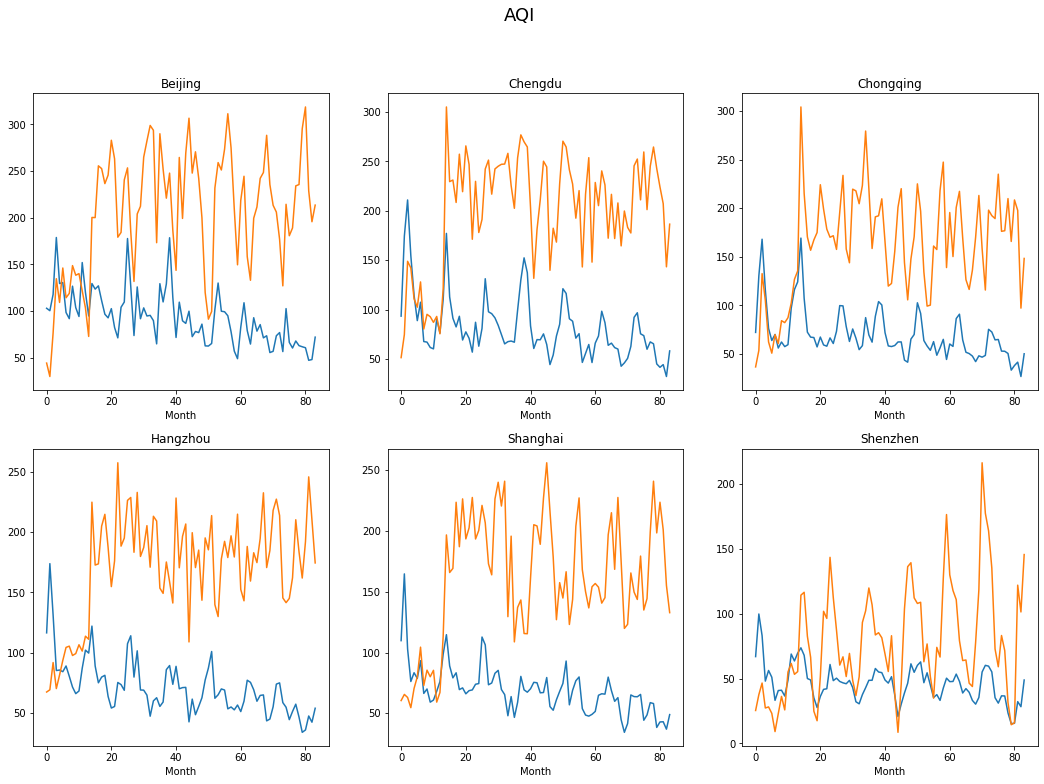

In [17]:
# subplot(2*3)
figure_line,ax_line=plt.subplots(2,3)
figure_line.suptitle('AQI',fontsize=18)
for i in range(2):
    for j in range(3):
        ax_line[i][j].set_title(city_name_list[i*3+j])
        ax_line[i][j].set_xlabel('Month')

# -----------------------------------------------------------------------------------
ax_line[0][0].plot(smooth(data_bj,'AQI_index',window_size),label='AQI index')
ax_line[0][0].plot(smooth(data_bj,'AQI_rank',window_size),label='AQI rank')

ax_line[0][1].plot(smooth(data_cd,'AQI_index',window_size),label='AQI index')
ax_line[0][1].plot(smooth(data_cd,'AQI_rank',window_size),label='AQI rank')

ax_line[0][2].plot(smooth(data_cq,'AQI_index',window_size),label='AQI index')
ax_line[0][2].plot(smooth(data_cq,'AQI_rank',window_size),label='AQI rank')

ax_line[1][0].plot(smooth(data_hz,'AQI_index',window_size),label='AQI index')
ax_line[1][0].plot(smooth(data_hz,'AQI_rank',window_size),label='AQI rank')

ax_line[1][1].plot(smooth(data_sh,'AQI_index',window_size),label='AQI index')
ax_line[1][1].plot(smooth(data_sh,'AQI_rank',window_size),label='AQI rank')

ax_line[1][2].plot(smooth(data_sz,'AQI_index',window_size),label='AQI index')
ax_line[1][2].plot(smooth(data_sz,'AQI_rank',window_size),label='AQI rank')
# -----------------------------------------------------------------------------------
lines, labels = figure_line.axes[-1].get_legend_handles_labels()
# figure_line.legend(lines, labels, loc = 'best',fontsize=20)

print(figure_line)

通过上面的图片我们可以看出，虽然六座城市的AQI都随着时间呈现下降趋势，但其空气质量的排名在全国却没有呈现相应的变化。对此我们可以有两种理解方式：
* 全国空气质量全面向好
* 计算AQI的方式发生了变化

**地图**加**热力图**的方式可以很直观地呈现地区的环境空气质量指数，也很方便我们进行横向对比。

本项目在这里展示了2018年上述六座城市的空气质量指数热力图。

In [18]:
from pyecharts import Map

def air_quality(column_name,year,func='mean'):
    # 由于地图类型限制，以城市所在省份作为地图上城市的位置
    province = ['北京','四川','重庆','浙江','上海','广东']
# -----------------------------------------------------------------------------------
    values = [
            get_des(data_bj,column_name,year,func),
            get_des(data_cd,column_name,year,func),
            get_des(data_cq,column_name,year,func),
            get_des(data_hz,column_name,year,func),
            get_des(data_sh,column_name,year,func),
            get_des(data_sz,column_name,year,func)
             ]
# -----------------------------------------------------------------------------------
    return province,values

province, values = air_quality('AQI_index',2018)
# 定义地图标题等信息
map = Map("Air Quality", 'China', width=1800, height=900)
# 为地图传入数据
map.add("", province, values, visual_range=[min(values),max(values)], maptype='china', is_visualmap=True,visual_text_color='#000')
# 渲染地图为可交互的html格式
map.render(path="./heatmap.html")

ModuleNotFoundError: No module named 'pyecharts'

使用**条状图**可视化每座城市空气质量为六座城市中最好的天数与空气质量为六座城市中最差的天数也有助于我们加深对每座城市的空气质量的了解。

统计了2013-2020年六座城市横向对比每日空气质量最好的城市和空气质量最差的城市，并通过一张条形图呈现了最好/最坏空气质量天数。

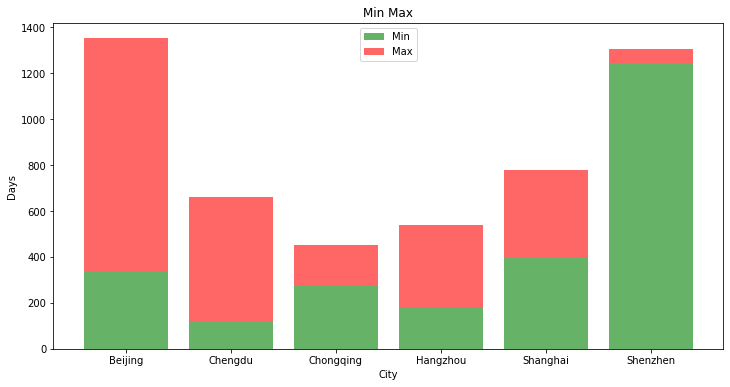

In [19]:
# 统计天数并返回一个list
def ret_best(column_name):
    citys_data = pd.concat([data_bj[column_name], data_cd[column_name],data_cq[column_name],data_hz[column_name],data_sh[column_name],data_sz[column_name]], axis=1, join='outer')
    citys_data.columns = city_name_list
    data_min = pd.DataFrame(np.zeros(shape=(1,6)))
    data_min.columns = city_name_list
    data_max = pd.DataFrame(np.zeros(shape=(1,6)))
    data_max.columns = city_name_list
    temp_min = citys_data.idxmin(axis=1)
    temp_max = citys_data.idxmax(axis=1)
    for i in range(len(citys_data)):
        data_min[temp_min[i]] += 1
        data_max[temp_max[i]] += 1
    return data_min,data_max

df1,df2 = ret_best('AQI_index')
plt.figure(figsize=(12,6))
# 红色代表空气质量最差，绿色代表空气质量最好
rects1 = plt.bar(range(6), df1.loc[0].values.tolist(), alpha=0.6, color='green', label="Min")
rects2 = plt.bar(range(6), df2.loc[0].values.tolist(), alpha=0.6, color='red', label="Max", bottom=df1.loc[0].values.tolist())
plt.xlabel('City')
plt.xticks(range(6),[column for column in df1])
plt.ylabel('Days')
plt.title('Min Max')
plt.legend()
plt.show()

可以看出，深圳自2013年来的最优空气质量天数遥遥领先，其余五座城市的最优空气质量天数则比较均衡。北京自2013年来的最差空气质量天数不出所料的稳居第一，深圳则表现优秀，很少有最差的空气质量。

对AQI做了如此多的分析，我们也不能忘了AQI的组成成分们，但在统计分析过程中注意到不同污染物的数值具有很大的数值差异，将不同的污染物一起分析不具有意义。**箱线图**很直观的呈现了均值，极值，异常值等信息。通过**箱线图**横向呈现六座城市的六种污染物数据也不失为一种好的分析方法。

Figure(1440x1080)


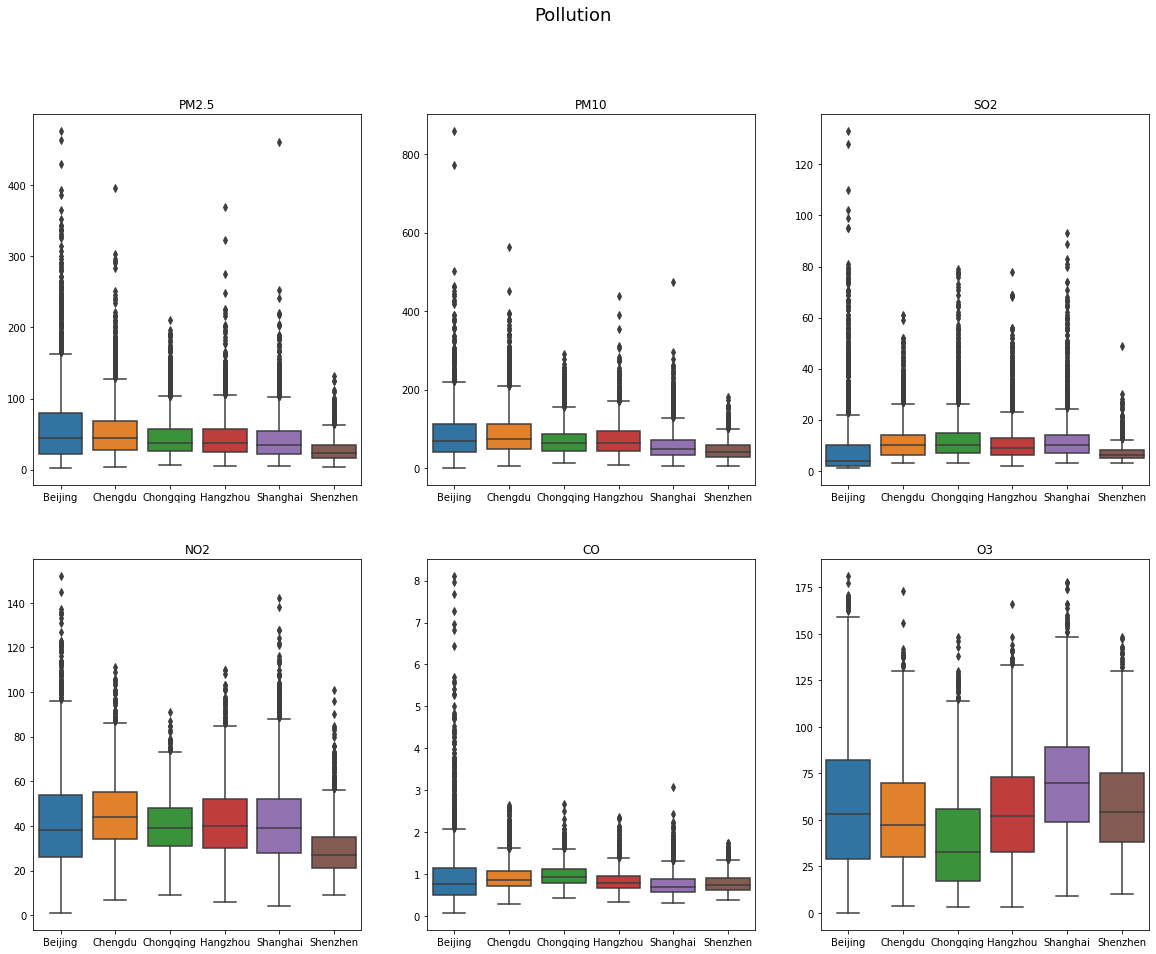

In [20]:
# subplot (2*3)
rcParams['figure.figsize'] = (20,15)
figure_box,ax_box = plt.subplots(2,3)
figure_box.suptitle('Pollution',fontsize=18)

# 使用seaborn库画箱线图
for i in range(2):
    for j in range(3):
        # 将数据抽取出来重组
        df = pd.concat([data_bj[poll_name_list[i*3+j]], data_cd[poll_name_list[i*3+j]],data_cq[poll_name_list[i*3+j]],data_hz[poll_name_list[i*3+j]],data_sh[poll_name_list[i*3+j]],data_sz[poll_name_list[i*3+j]]], axis=1, join='outer')
        df.columns = city_name_list
        sns.boxplot(data=df,ax=ax_box[i][j])
        ax_box[i][j].set_title(poll_name_list[i*3+j])
print(figure_box)

通过箱线图我们可以看出，在多种污染物上北京的数据分布都更广泛，其余五座城市，特别是深圳的数据分布则更窄一些。六座城市的各项污染物指标在均值上也并未呈现较大差异，这或许与直接统计总计8年的均值有关，太粗的粒度抹除了部分信息。

经过上面所有的的数据统计与数据可视化分析我们也不难发现，2013-2020年深圳总是空气质量较好，北京总是空气质量较差

## LSTM Train
## 数据预处理——机器学习

In [21]:
rcParams['figure.figsize'] = (10,8)
# 定义scaler：MinMax
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

# 归一化
def normalization(city_data):
    AQI_data = scaler.fit_transform(city_data.values.reshape(-1,1))
    return AQI_data

# 反归一化
def inverse_normalization(city_data):
    AQI_inverse = scaler.inverse_transform(city_data)
    return AQI_inverse

# 划分数据
def split(city_data):
    split = int(len(city_data)*training_set_size)
    train = city_data[:split]
    test = city_data[split+1:]
    return train,test

# 画图
def plot(title,ylabel,xlabel,data,sta=0):
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(data[sta:])
def plot_AQI(city_data,window_size):
    AQI_list = smooth(city_data,'AQI_index',window_size)
    plot('AQI','AQI index','time',AQI_list)

划分train data和test data

In [22]:
train_set_sh,test_set_sh = split(data_sh['AQI_index'])
train_set_sh = normalization(train_set_sh)
test_set_sh = normalization(test_set_sh)

### 构建数据集

In [23]:
# 以窗口大小创建数据集
def creat_dataset(dataset,look_back):
    data_x = []
    data_y = []
    for i in range(len(dataset)-look_back):
        data_x.append(dataset[i:i+look_back])
        data_y.append(dataset[i+look_back])
    return np.asarray(data_x).reshape(-1, 1, look_back),np.asarray(data_y).reshape(-1, 1, 1)#将训练数据调整成pytorch中lstm算法的输入维度  (seq_len,batch_size(指有几个batch),input_size) #将目标值调整成pytorch中lstm算法的输出维度



x_train_sh, y_train_sh = creat_dataset(train_set_sh,look_back)

### 超参数设置（2）

In [24]:
epoch = 1000
lr = 0.08
hidden_layer_size = 32
num_layers = 4
# 使用gpu加速训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
loss_list = []

cuda


### 定义LSTM网络

In [25]:
# seq_len = window_size
# batch = 1
class RNN(nn.Module):
    def __init__(self):
        super(RNN,self).__init__()
        # input_size = lookback
        self.lstm = nn.LSTM(look_back,hidden_layer_size,num_layers)
        #线性拟合 output_size = 1
        self.out = nn.Linear(hidden_layer_size,1) 
        
        
    def forward(self,x):
        x1,_ = self.lstm(x)
        a,b,c = x1.shape
        # 线性层输入:二维数据，stm输出:三维数据
        # 输出的特征维度不能变
        out = self.out(x1.view(-1,c))
        # 循环神经网络，把二维output调整成三维数据，下一次循环使用
        out1 = out.view(a,b,-1)
        return out1

### 实例化网络并训练

优化函数：Adam

损失函数：MSELoss

In [26]:
rnn = RNN().to(device)
print(rnn)
optimizer = torch.optim.Adam(rnn.parameters(),lr = 0.02)
loss_func = nn.MSELoss().to(device)

RNN(
  (lstm): LSTM(30, 32, num_layers=4)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


定义训练函数

In [ ]:
def train(x_train, y_train):    
    for i in range(epoch):
        x = torch.from_numpy(x_train).type(torch.FloatTensor).to(device)
        y = torch.from_numpy(y_train).type(torch.FloatTensor).to(device)
        out = rnn(x).to(device)
        loss = loss_func(out,y)
        loss_list.append(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if np.mod(i+1,5)==0:
            print('Epoch:{}, Loss:{:.5f}'.format(i+1, loss.item()))
            
train(x_train_sh,y_train_sh)

Epoch:5, Loss:0.01100
Epoch:10, Loss:0.01099
Epoch:15, Loss:0.00976
Epoch:20, Loss:0.00900
Epoch:25, Loss:0.00894
Epoch:30, Loss:0.00896
Epoch:35, Loss:0.00879
Epoch:40, Loss:0.00873
Epoch:45, Loss:0.00849
Epoch:50, Loss:0.00800
Epoch:55, Loss:0.00791
Epoch:60, Loss:0.00772
Epoch:65, Loss:0.00749
Epoch:70, Loss:0.00722
Epoch:75, Loss:0.00681
Epoch:80, Loss:0.00625
Epoch:85, Loss:0.00574
Epoch:90, Loss:0.00660
Epoch:95, Loss:0.00620
Epoch:100, Loss:0.00612
Epoch:105, Loss:0.00556
Epoch:110, Loss:0.00555
Epoch:115, Loss:0.00538
Epoch:120, Loss:0.00535
Epoch:125, Loss:0.00525
Epoch:130, Loss:0.00517
Epoch:135, Loss:0.00510
Epoch:140, Loss:0.00500
Epoch:145, Loss:0.00491
Epoch:150, Loss:0.00482
Epoch:155, Loss:0.00474
Epoch:160, Loss:0.00465
Epoch:165, Loss:0.00454
Epoch:170, Loss:0.00441
Epoch:175, Loss:0.00426
Epoch:180, Loss:0.00418
Epoch:185, Loss:0.00412
Epoch:190, Loss:0.00409
Epoch:195, Loss:0.00386
Epoch:200, Loss:0.00376
Epoch:205, Loss:0.00365
Epoch:210, Loss:0.00355
Epoch:215, L

可视化loss曲线

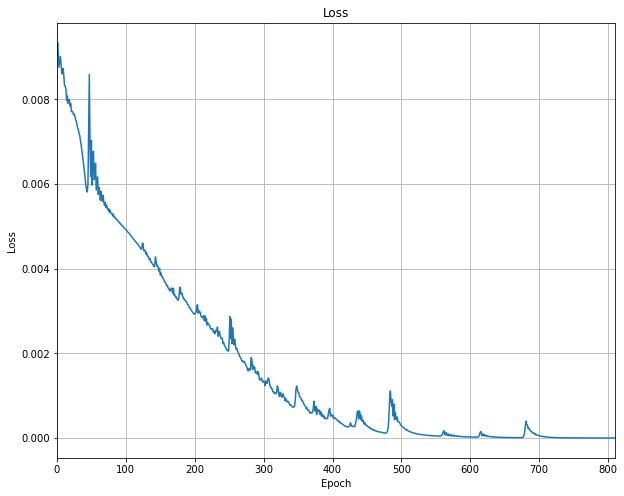

In [25]:
plot('Loss','Loss','Epoch',data=loss_list,sta=10)

## LSTM Test

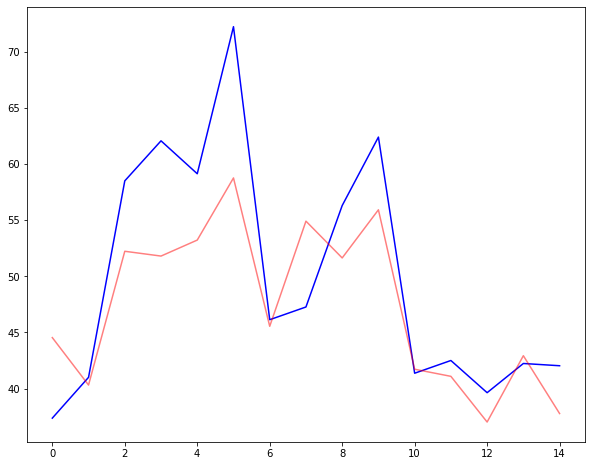

In [26]:
# 测试
rnn.eval()
#构建数据集
x_test_sh,y_test_sh = creat_dataset(test_set_sh,look_back)

def test_rnn(x_test,y_test):
    y_pred = rnn(torch.from_numpy(x_test).type(torch.FloatTensor).to(device))

    pred = y_pred.data.cpu().numpy().reshape(-1,1)
    test = y_test.reshape(-1,1)
    pred_list = []
    test_list = []
    pred_sum = 0
    test_sum = 0

    for i in range(len(pred)):
        pred_sum += pred[i]
        test_sum += test[i]
        if np.mod(i+1,look_back)==0:
            pred_list.append(pred_sum/look_back)
            test_list.append(test_sum/look_back)
            pred_sum = 0
            test_sum = 0
    
    plt.plot(inverse_normalization(test_list),color='b')
    plt.plot(inverse_normalization(pred_list),color='r',alpha=0.5)

test_rnn(x_test_sh,y_test_sh)

可以看出在测试集上对趋势的预测与实际情况还是比较吻合的，说明这是一个可用的网络结构

### 对未来30天进行预测

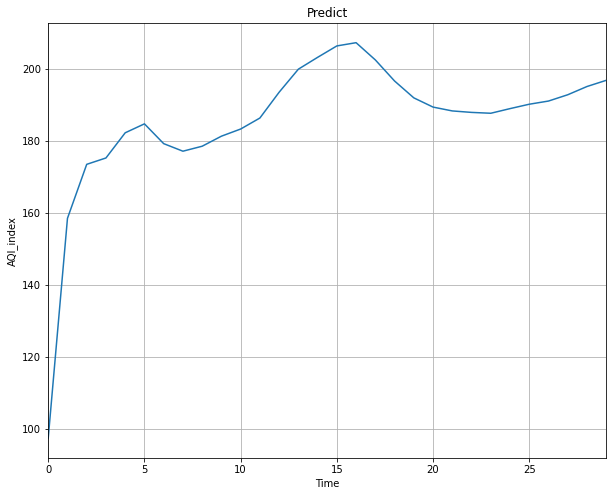

In [27]:
time_forward = 30

# 迭代的将预测得到的第a天的数据加入数据集用作预测第a+1天
def fut_iter(in_seq):
    x = torch.from_numpy(in_seq).type(torch.FloatTensor).to(device)
    out_data = rnn(x).to(device)
    
    return out_data
def pred_future(city_data,time_forward=30):
    AQI_data = normalization(city_data['AQI_index'])
    # 创建初始数据集
    data,_ = creat_dataset(AQI_data,look_back)
    pred = rnn(torch.from_numpy(data).type(torch.FloatTensor).to(device))
    pred = pred.data.cpu().numpy().reshape(-1,1)

    in_seq = np.delete(data[-1,0],0)
    in_seq = np.append(in_seq,pred[-1]).reshape(1,-1,look_back)
    for i in range(time_forward):
        out = fut_iter(in_seq).item()
        pred = np.append(pred,out)
        in_seq = np.delete(in_seq[-1,0],0)
        # 扩增数据集
        in_seq = np.append(in_seq,out).reshape(1,-1,look_back)
    pred = pred.reshape(-1,1)
    # 反归一化
    pred = inverse_normalization(pred)
    plot('Predict','AQI_index','Time',data=pred,sta=-time_forward)

pred_future(data_sh,time_forward)

### 结果分析
本次项目基本达到了预期，在数据分析方面，完成了对环境空气质量指数的数据统计分析与可视化，得到了不少关于空气质量的信息。在时序预测方面，训练过程中的loss快速收敛，测试过程中也对空气质量指数有较为正确预测的趋势，虽然结果的准确性有待考量，但是通过合理的设置窗口大小与调整其他超参数可以更好的逼近实际情况，在本项目中我第一次使用了LSTM这种时间递归神经网络，发现这种神经网络的确非常适合进行时间序列的预测，是个很不错的预测手段。